# Load Subject Info

In [1]:
import pandas as pd
df = pd.read_excel(r"C:\Users\Micha\OneDrive - Høyskolen Kristiania\MsC Business Analytics\Master Thesis\Python\Subject_info.xlsx")

# Functions 

## Skull Strip of MRI

In [ ]:
import subprocess
import os
from pathlib import Path
import json

def skull_strip_all_mri(input_dir, output_dir, parameters=None):
    """
    Skull strip all MRI NIfTI files found in the input directory, save the output
    in the output directory with the same file name, and return the details.

    Parameters:
    - input_dir: Directory containing the input .nii files.
    - output_dir: Directory where the skull-stripped files will be saved.
    - parameters: Additional parameters to pass to the bet command.

    Returns:
    A list of dictionaries with details of the skull stripping process for each file.
    """
    # Ensure the output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    input_dir_docker = input_dir.replace("\\", "/")
    output_dir_docker = output_dir.replace("\\", "/")
    
    process_details = []  # To hold details of each processed file

    for nifti_file in Path(input_dir).glob('*.nii'):
        if nifti_file.stem.endswith('_MRI'):
            input_file = nifti_file.name
            output_file = nifti_file.name  # Use the same name for output

            docker_command = f'docker run --rm -v "{input_dir_docker}:/workdir/input" -v "{output_dir_docker}:/workdir/output" -t fsl:5.0 bet /workdir/input/{input_file} /workdir/output/{output_file} {parameters}'
            
            try:
                subprocess.run(docker_command, check=True, shell=True)
                print(f"Skull stripping completed successfully for {input_file}.")
                process_details.append({'input_file': input_file, 'output_file': output_file, 'parameters': parameters, 'status': 'Success'})
            except subprocess.CalledProcessError as e:
                print(f"An error occurred during processing {input_file}: {e}")
                process_details.append({'input_file': input_file, 'output_file': output_file, 'parameters': parameters, 'status': f'Failed: {e}'})
    
    return process_details




In [ ]:
# Example usage
input_dir = r"D:\Data\Preprocessed\nifti"
output_dir = r"D:\Data\Preprocessed\skullstripped"
parameters = "-f 0.5"  # Adjust parameters as needed
details = skull_strip_all_mri(input_dir, output_dir, parameters)

# Optionally, save 'details' to a JSON file for record-keeping
with open('skull_strip_details.json', 'w') as f:
    json.dump(details, f, indent=4)

## Spatial Normalization

BRAIN MASK USED:
https://nist.mni.mcgill.ca/mni-icbm152-non-linear-6th-generation-symmetric-average-brain-stereotaxic-registration-model/

In [7]:
import subprocess
import os
from tqdm import tqdm

def run_flirt_on_folder(source_folder, target_folder, template_folder):
    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)
    
    # Define the template file path
    template_file = os.path.join(template_folder, 'icbm_avg_152_t1_tal_nlin_symmetric_VI.nii')
    
    # Get all .nii files in the source folder
    nii_files = [f for f in os.listdir(source_folder) if f.endswith('.nii')]
    
    # Initialize progress bar
    with tqdm(total=len(nii_files), desc="Processing .nii Files") as pbar:
        for filename in nii_files:
            # Construct the full paths for input and output
            input_file_path = os.path.join(source_folder, filename)
            output_file_path = os.path.join(target_folder, filename)
            
            # Construct the Docker run command
            docker_command = f"docker run --rm -v {source_folder}:/data -v {template_folder}:/template fsl:5.0 flirt -ref /template/icbm_avg_152_t1_tal_nlin_symmetric_VI.nii -in /data/{filename} -out /data/{filename} > {output_file_path}_flirt_output.log 2>&1"
            
            # Execute the command
            subprocess.run(docker_command, shell=True)
            
            # Update progress bar
            pbar.update(1)



In [ ]:
# Example usage
source_folder = r"D:\Data\Preprocessed\skullstripped"
target_folder = r"D:\Data\Preprocessed\spatial_normalization"
template_folder = r"D:\Downloads\mni_icbm152_nl_VI_nifti"

run_flirt_on_folder(source_folder, target_folder, template_folder)


## GM CUTTING

Brain Segmentation

In [8]:
import subprocess
import os
from tqdm import tqdm

def run_brain_segmentation_on_directory(input_directory: str, output_directory: str):
    """
    Processes all .nii files in the specified input directory using FSL's FAST tool,
    saving the outputs in the specified output directory. Displays a progress bar.

    Args:
    input_directory (str): Path to the directory containing .nii files to process.
    output_directory (str): Path to the directory where output files should be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # List all .nii files in the input directory
    nii_files = [file for file in os.listdir(input_directory) if file.endswith('.nii')]

    # Check if there are any .nii files in the directory
    if not nii_files:
        print("No .nii files found in the input directory.")
        return

    for nii_file in tqdm(nii_files, desc="Processing .nii files", unit="file"):
        # Full path to the input file in the local system
        input_file_path = os.path.join(input_directory, nii_file)
        # Name for the output file, derived from the input file name
        output_file_name = os.path.splitext(nii_file)[0] + "_segmented"

        # Adjusted Docker command
        docker_command = [
            "docker", "run", "--rm",
            "-v", f"{input_directory}:/input",  # Mount the input directory
            "-v", f"{output_directory}:/output",  # Mount the output directory
            "fsl:5.0", "fast",
            "-o", f"/output/{output_file_name}",
            f"/input/{nii_file}"
        ]

        # Execute the Docker command
        result = subprocess.run(docker_command, capture_output=True, text=True)

        # Check for errors and print them
        if result.returncode != 0:
            tqdm.write(f"Error processing {nii_file}:")
            tqdm.write(result.stderr)


        # Execute the Docker command
        result = subprocess.run(docker_command, capture_output=True, text=True)

        # Check for errors and print them
        if result.returncode != 0:
            tqdm.write(f"Error processing {nii_file}:")
            tqdm.write(result.stderr)



In [19]:
input_dir = r"D:\Data\Preprocessed\spatial_normalization"
output_dir = r"D:\Data\Preprocessed\GM Cutting"
run_brain_segmentation_on_directory(input_dir, output_dir)

Processing .nii files: 100%|██████████| 143/143 [18:05:21<00:00, 455.39s/file]


Moving away files that are not GM

In [20]:
import os
import shutil

source_dir = r'D:\Data\Preprocessed\GM Cutting'
target_dir = r'D:\Data\Preprocessed\GM Cutting\Archive'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for filename in os.listdir(source_dir):
    if 'pve_1' not in filename:
        shutil.move(os.path.join(source_dir, filename), target_dir)

## PET CO-registration with MRI

In [30]:
from pathlib import Path
import subprocess
from tqdm import tqdm
import pandas as pd

def co_register_pet_with_mri(df, base_input_directory, base_mri_directory, output_directory):
    Path(output_directory).mkdir(parents=True, exist_ok=True)
    unique_subjects = df['Subject'].unique()
    with tqdm(total=len(unique_subjects), desc="Co-registering PET with MRI", unit="subject") as pbar:
        for subject_id in unique_subjects:
            pet_file_path = Path(base_input_directory, f"{subject_id}_PET.nii").resolve()
            mri_file_path = Path(base_mri_directory, f"{subject_id}_MRI.nii").resolve()

            print(f"Looking for PET file at: {pet_file_path}")
            print(f"Looking for MRI file at: {mri_file_path}")

            if not pet_file_path.exists() or not mri_file_path.exists():
                print(f"Files for subject {subject_id} not found.")
                pbar.update(1)
                continue

            output_file_name = f"{subject_id}_PET_coregistered.nii"
            output_file_path = Path(output_directory, output_file_name).resolve()

            docker_command = [
                "docker", "run", "--rm",
                "-v", f"{pet_file_path.parent}:/data",
                "-v", f"{mri_file_path.parent}:/reference",
                "-v", f"{output_directory}:/output",
                "fsl:5.0", "flirt",
                "-in", f"/data/{pet_file_path.name}",
                "-ref", f"/reference/{mri_file_path.name}",
                "-out", f"/output/{output_file_path.name}",
                "-omat", f"/output/{subject_id}_transformation_matrix.mat",
                "-cost", "mutualinfo",
                "-dof", "6",
                "-searchrx", "-180", "180",
                "-searchry", "-180", "180",
                "-searchrz", "-180", "180",
                "-interp", "trilinear"
            ]

            result = subprocess.run(docker_command, capture_output=True, text=True)

            if result.returncode != 0:
                print(f"Error co-registering {subject_id}: {result.stderr}")

            pbar.update(1)

if __name__ == "__main__":
    input_pet_directory = r"D:\Data\Preprocessed\1. nifti"
    reference_mri_directory = r"D:\Data\Preprocessed\3. spatial_normalization"
    output_pet_directory = r"D:\Data\Preprocessed\5. Co-registered PET"
    co_register_pet_with_mri(df, input_pet_directory, reference_mri_directory, output_pet_directory)


Co-registering PET with MRI:   0%|          | 0/143 [00:00<?, ?subject/s]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_0295_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_0295_MRI.nii


Co-registering PET with MRI:   1%|          | 1/143 [00:24<57:31, 24.30s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_0413_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_0413_MRI.nii


Co-registering PET with MRI:   1%|▏         | 2/143 [00:51<1:00:28, 25.73s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_0685_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_0685_MRI.nii


Co-registering PET with MRI:   2%|▏         | 3/143 [01:14<57:50, 24.79s/subject]  

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_0729_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_0729_MRI.nii


Co-registering PET with MRI:   3%|▎         | 4/143 [01:40<58:24, 25.21s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_1155_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_1155_MRI.nii


Co-registering PET with MRI:   3%|▎         | 5/143 [02:07<59:12, 25.74s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_1261_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_1261_MRI.nii


Co-registering PET with MRI:   4%|▍         | 6/143 [02:33<59:01, 25.85s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_1268_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_1268_MRI.nii


Co-registering PET with MRI:   5%|▍         | 7/143 [02:56<56:20, 24.86s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_1280_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_1280_MRI.nii


Co-registering PET with MRI:   6%|▌         | 8/143 [03:20<55:55, 24.85s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_2010_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_2010_MRI.nii


Co-registering PET with MRI:   6%|▋         | 9/143 [03:46<56:17, 25.20s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_2043_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_2043_MRI.nii


Co-registering PET with MRI:   7%|▋         | 10/143 [04:13<56:59, 25.71s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_2073_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_2073_MRI.nii


Co-registering PET with MRI:   8%|▊         | 11/143 [04:37<55:27, 25.21s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4171_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4171_MRI.nii


Co-registering PET with MRI:   8%|▊         | 12/143 [05:05<56:58, 26.10s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4213_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4213_MRI.nii


Co-registering PET with MRI:   9%|▉         | 13/143 [05:33<57:26, 26.51s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4219_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4219_MRI.nii


Co-registering PET with MRI:  10%|▉         | 14/143 [05:55<54:24, 25.30s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4225_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4225_MRI.nii


Co-registering PET with MRI:  10%|█         | 15/143 [06:22<54:29, 25.54s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4229_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4229_MRI.nii


Co-registering PET with MRI:  11%|█         | 16/143 [06:48<54:22, 25.69s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4237_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4237_MRI.nii


Co-registering PET with MRI:  12%|█▏        | 17/143 [07:14<54:12, 25.81s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4251_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4251_MRI.nii


Co-registering PET with MRI:  13%|█▎        | 18/143 [07:41<55:01, 26.41s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4262_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4262_MRI.nii


Co-registering PET with MRI:  13%|█▎        | 19/143 [08:08<54:39, 26.44s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4270_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4270_MRI.nii


Co-registering PET with MRI:  14%|█▍        | 20/143 [08:32<52:56, 25.83s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4447_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4447_MRI.nii


Co-registering PET with MRI:  15%|█▍        | 21/143 [09:01<53:56, 26.53s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4473_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4473_MRI.nii


Co-registering PET with MRI:  15%|█▌        | 22/143 [09:24<51:48, 25.69s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4521_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4521_MRI.nii


Co-registering PET with MRI:  16%|█▌        | 23/143 [09:57<55:43, 27.86s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4654_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4654_MRI.nii


Co-registering PET with MRI:  17%|█▋        | 24/143 [10:34<1:00:20, 30.43s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4746_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4746_MRI.nii


Co-registering PET with MRI:  17%|█▋        | 25/143 [10:57<55:40, 28.31s/subject]  

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_4799_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_4799_MRI.nii


Co-registering PET with MRI:  18%|█▊        | 26/143 [11:23<53:34, 27.47s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\002_S_5018_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\002_S_5018_MRI.nii


Co-registering PET with MRI:  19%|█▉        | 27/143 [11:47<51:24, 26.59s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_2185_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_2185_MRI.nii


Co-registering PET with MRI:  20%|█▉        | 28/143 [12:19<53:54, 28.13s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_2308_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_2308_MRI.nii


Co-registering PET with MRI:  20%|██        | 29/143 [12:57<59:29, 31.31s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4039_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4039_MRI.nii


Co-registering PET with MRI:  21%|██        | 30/143 [13:38<1:04:18, 34.14s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4058_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4058_MRI.nii


Co-registering PET with MRI:  22%|██▏       | 31/143 [14:06<1:00:24, 32.36s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4079_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4079_MRI.nii


Co-registering PET with MRI:  22%|██▏       | 32/143 [14:46<1:03:39, 34.41s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4080_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4080_MRI.nii


Co-registering PET with MRI:  23%|██▎       | 33/143 [15:21<1:03:48, 34.81s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4093_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4093_MRI.nii


Co-registering PET with MRI:  24%|██▍       | 34/143 [15:45<57:14, 31.51s/subject]  

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4263_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4263_MRI.nii


Co-registering PET with MRI:  24%|██▍       | 35/143 [16:12<54:17, 30.16s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4328_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4328_MRI.nii


Co-registering PET with MRI:  25%|██▌       | 36/143 [16:45<55:12, 30.96s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4401_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4401_MRI.nii


Co-registering PET with MRI:  26%|██▌       | 37/143 [17:16<54:42, 30.97s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4576_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4576_MRI.nii


Co-registering PET with MRI:  27%|██▋       | 38/143 [17:45<53:06, 30.35s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4577_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4577_MRI.nii


Co-registering PET with MRI:  27%|██▋       | 39/143 [18:25<57:28, 33.16s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4615_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4615_MRI.nii


Co-registering PET with MRI:  28%|██▊       | 40/143 [19:01<58:32, 34.10s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\014_S_4668_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\014_S_4668_MRI.nii


Co-registering PET with MRI:  29%|██▊       | 41/143 [19:36<58:19, 34.31s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_2087_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_2087_MRI.nii


Co-registering PET with MRI:  29%|██▉       | 42/143 [20:13<59:05, 35.10s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_2167_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_2167_MRI.nii


Co-registering PET with MRI:  30%|███       | 43/143 [20:46<57:25, 34.45s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_2263_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_2263_MRI.nii


Co-registering PET with MRI:  31%|███       | 44/143 [21:13<53:33, 32.46s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_2379_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_2379_MRI.nii


Co-registering PET with MRI:  31%|███▏      | 45/143 [21:54<57:01, 34.91s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4173_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4173_MRI.nii


Co-registering PET with MRI:  32%|███▏      | 46/143 [22:22<52:50, 32.68s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4196_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4196_MRI.nii


Co-registering PET with MRI:  33%|███▎      | 47/143 [22:56<52:56, 33.09s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4266_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4266_MRI.nii


Co-registering PET with MRI:  34%|███▎      | 48/143 [23:24<50:07, 31.65s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4291_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4291_MRI.nii


Co-registering PET with MRI:  34%|███▍      | 49/143 [23:51<47:14, 30.15s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4320_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4320_MRI.nii


Co-registering PET with MRI:  35%|███▍      | 50/143 [24:14<43:27, 28.04s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4444_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4444_MRI.nii


Co-registering PET with MRI:  36%|███▌      | 51/143 [24:50<46:51, 30.57s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4805_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4805_MRI.nii


Co-registering PET with MRI:  36%|███▋      | 52/143 [25:16<44:08, 29.10s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_4922_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_4922_MRI.nii


Co-registering PET with MRI:  37%|███▋      | 53/143 [25:50<45:46, 30.51s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\022_S_5004_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\022_S_5004_MRI.nii


Co-registering PET with MRI:  38%|███▊      | 54/143 [26:17<43:56, 29.62s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\032_S_0214_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\032_S_0214_MRI.nii
Files for subject 032_S_0214 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\032_S_0479_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\032_S_0479_MRI.nii
Files for subject 032_S_0479 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\032_S_0677_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\032_S_0677_MRI.nii
Files for subject 032_S_0677 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\032_S_1169_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\032_S_1169_MRI.nii
Files for subject 032_S_1169 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\032_S_2119_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\032_S_2119_MRI.nii
Files for subject 03

Co-registering PET with MRI:  55%|█████▍    | 78/143 [26:49<04:08,  3.83s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\114_S_4379_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\114_S_4379_MRI.nii


Co-registering PET with MRI:  55%|█████▌    | 79/143 [27:22<05:42,  5.36s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\114_S_4404_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\114_S_4404_MRI.nii


Co-registering PET with MRI:  56%|█████▌    | 80/143 [28:02<08:06,  7.72s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\114_S_5047_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\114_S_5047_MRI.nii


Co-registering PET with MRI:  57%|█████▋    | 81/143 [28:42<10:56, 10.59s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\128_S_2002_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\128_S_2002_MRI.nii
Files for subject 128_S_2002 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\128_S_2003_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\128_S_2003_MRI.nii
Files for subject 128_S_2003 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\128_S_2011_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\128_S_2011_MRI.nii
Files for subject 128_S_2011 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\128_S_2036_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\128_S_2036_MRI.nii
Files for subject 128_S_2036 not found.
Looking for PET file at: D:\Data\Preprocessed\1. nifti\128_S_2045_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\128_S_2045_MRI.nii
Files for subject 12

Co-registering PET with MRI:  77%|███████▋  | 110/143 [29:11<01:40,  3.03s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_0767_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_0767_MRI.nii


Co-registering PET with MRI:  78%|███████▊  | 111/143 [29:38<02:05,  3.92s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_1004_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_1004_MRI.nii


Co-registering PET with MRI:  78%|███████▊  | 112/143 [30:04<02:36,  5.04s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_1052_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_1052_MRI.nii


Co-registering PET with MRI:  79%|███████▉  | 113/143 [30:28<03:11,  6.38s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_1255_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_1255_MRI.nii


Co-registering PET with MRI:  80%|███████▉  | 114/143 [30:54<03:53,  8.05s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_1378_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_1378_MRI.nii


Co-registering PET with MRI:  80%|████████  | 115/143 [31:19<04:38,  9.96s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_2210_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_2210_MRI.nii


Co-registering PET with MRI:  81%|████████  | 116/143 [31:44<05:24, 12.04s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_2333_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_2333_MRI.nii


Co-registering PET with MRI:  82%|████████▏ | 117/143 [32:09<06:07, 14.12s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4053_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4053_MRI.nii


Co-registering PET with MRI:  83%|████████▎ | 118/143 [32:35<06:48, 16.33s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4160_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4160_MRI.nii


Co-registering PET with MRI:  83%|████████▎ | 119/143 [33:00<07:20, 18.34s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4232_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4232_MRI.nii


Co-registering PET with MRI:  84%|████████▍ | 120/143 [33:29<07:56, 20.72s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4423_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4423_MRI.nii


Co-registering PET with MRI:  85%|████████▍ | 121/143 [33:54<08:01, 21.90s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4426_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4426_MRI.nii


Co-registering PET with MRI:  85%|████████▌ | 122/143 [34:26<08:31, 24.36s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4438_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4438_MRI.nii


Co-registering PET with MRI:  86%|████████▌ | 123/143 [34:55<08:33, 25.68s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4456_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4456_MRI.nii


Co-registering PET with MRI:  87%|████████▋ | 124/143 [35:41<09:57, 31.45s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4711_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4711_MRI.nii


Co-registering PET with MRI:  87%|████████▋ | 125/143 [36:07<08:56, 29.80s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4803_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4803_MRI.nii


Co-registering PET with MRI:  88%|████████▊ | 126/143 [36:35<08:18, 29.30s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4819_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4819_MRI.nii


Co-registering PET with MRI:  89%|████████▉ | 127/143 [37:03<07:42, 28.92s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4907_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4907_MRI.nii


Co-registering PET with MRI:  90%|████████▉ | 128/143 [37:40<07:51, 31.44s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\141_S_4976_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\141_S_4976_MRI.nii


Co-registering PET with MRI:  90%|█████████ | 129/143 [38:09<07:08, 30.63s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_1195_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_1195_MRI.nii


Co-registering PET with MRI:  91%|█████████ | 130/143 [38:40<06:38, 30.67s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_1202_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_1202_MRI.nii


Co-registering PET with MRI:  92%|█████████▏| 131/143 [39:05<05:50, 29.19s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_2060_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_2060_MRI.nii


Co-registering PET with MRI:  92%|█████████▏| 132/143 [39:38<05:32, 30.19s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4036_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4036_MRI.nii


Co-registering PET with MRI:  93%|█████████▎| 133/143 [40:08<05:00, 30.03s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4066_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4066_MRI.nii


Co-registering PET with MRI:  94%|█████████▎| 134/143 [40:32<04:15, 28.38s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4100_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4100_MRI.nii


Co-registering PET with MRI:  94%|█████████▍| 135/143 [40:58<03:42, 27.77s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4187_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4187_MRI.nii


Co-registering PET with MRI:  95%|█████████▌| 136/143 [41:31<03:24, 29.21s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4255_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4255_MRI.nii


Co-registering PET with MRI:  96%|█████████▌| 137/143 [42:10<03:12, 32.07s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4292_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4292_MRI.nii


Co-registering PET with MRI:  97%|█████████▋| 138/143 [42:37<02:33, 30.75s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4365_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4365_MRI.nii


Co-registering PET with MRI:  97%|█████████▋| 139/143 [43:12<02:06, 31.74s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4376_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4376_MRI.nii


Co-registering PET with MRI:  98%|█████████▊| 140/143 [43:46<01:37, 32.45s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4377_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4377_MRI.nii


Co-registering PET with MRI:  99%|█████████▊| 141/143 [44:16<01:03, 31.69s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4420_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4420_MRI.nii


Co-registering PET with MRI:  99%|█████████▉| 142/143 [44:38<00:29, 29.07s/subject]

Looking for PET file at: D:\Data\Preprocessed\1. nifti\941_S_4764_PET.nii
Looking for MRI file at: D:\Data\Preprocessed\3. spatial_normalization\941_S_4764_MRI.nii


Co-registering PET with MRI: 100%|██████████| 143/143 [45:17<00:00, 19.00s/subject]


In [ ]:
if __name__ == "__main__":
    input_pet_directory = r"D:\Data\Preprocessed\1. nifti"
    reference_mri_directory = r"D:\Data\Preprocessed\3. spatial_normalization"
    output_pet_directory = r"D:\Data\Preprocessed\5. Co-registered PET"
    co_register_pet_with_mri(df, input_pet_directory, reference_mri_directory, output_pet_directory)


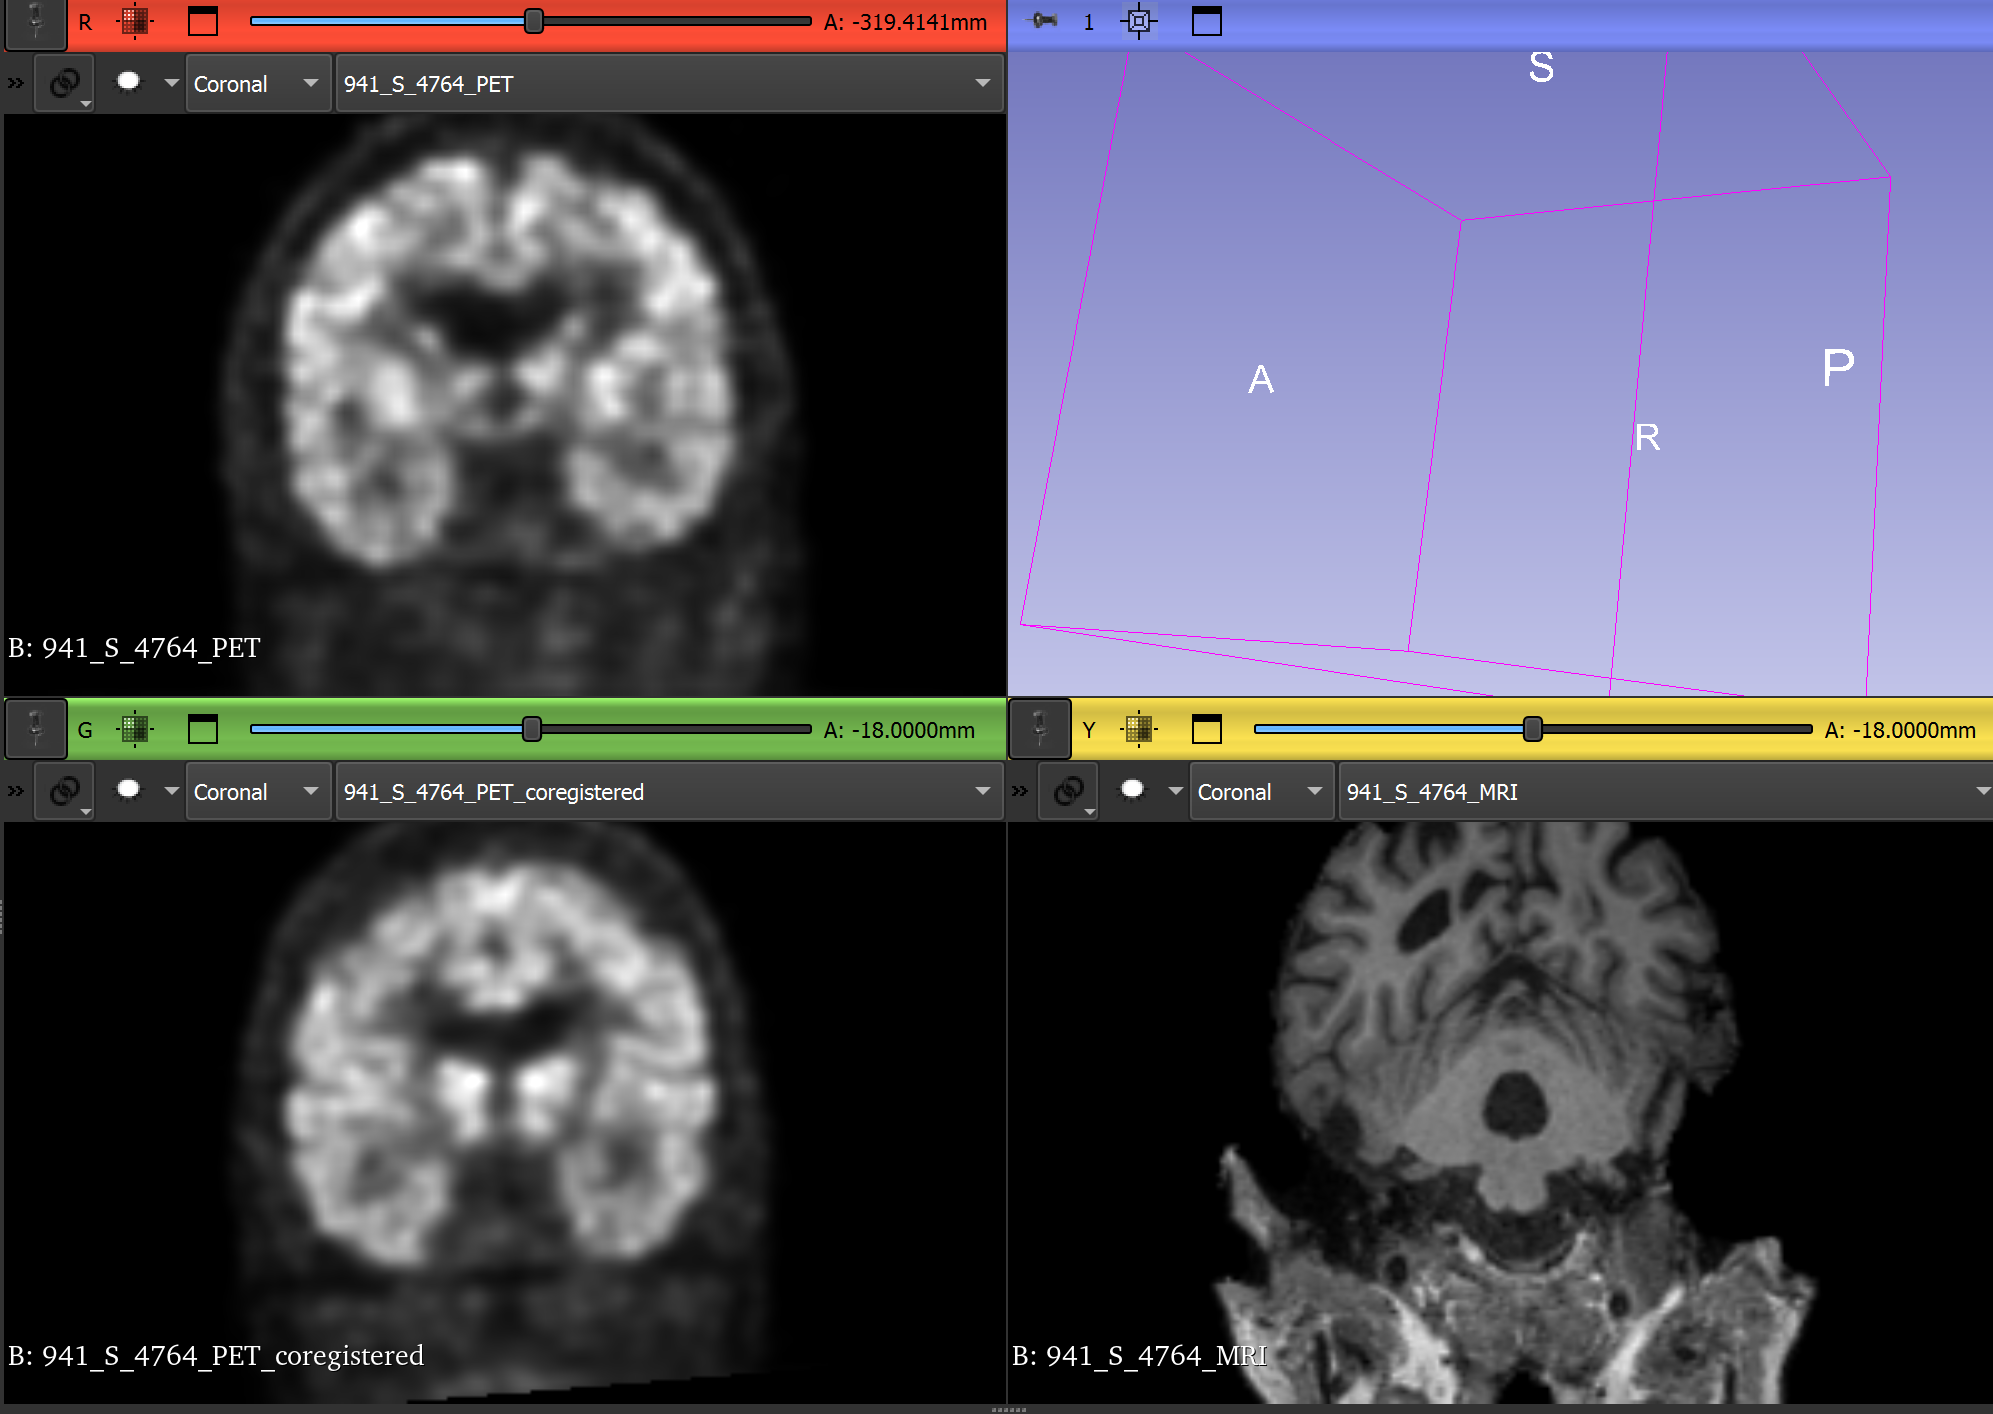

## Applying Anatomical GM Mask to PET

In [37]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def process_images(pet_dir, gm_mask_dir, output_dir, df):
 

    # Get unique Subject_IDs from the DataFrame
    subject_ids = df['Subject'].unique()
    
    # Set up the progress bar
    pbar = tqdm(total=len(subject_ids), desc="Processing Subjects")
    
    for subject_id in subject_ids:
        try:
            pet_path = os.path.join(pet_dir, f"{subject_id}_PET_coregistered.nii")
            gm_mask_path = os.path.join(gm_mask_dir, f"{subject_id}_MRI_segmented_pve_1.nii")
            
            if not os.path.exists(pet_path) or not os.path.exists(gm_mask_path):
                raise FileNotFoundError(f"File not found for subject {subject_id}")

            # Load the PET image
            pet_image = nib.load(pet_path)
            
            # Load the gray matter mask
            gm_mask = nib.load(gm_mask_path)
            
            # Ensure the PET image data and the mask are aligned in dimensions
            assert pet_image.shape == gm_mask.shape, "PET image and GM mask must have the same dimensions"
            
            # Apply the mask
            masked_data = pet_image.get_fdata() * gm_mask.get_fdata()
            
            # Create a new NIfTI image for the masked PET data
            masked_pet_image = nib.Nifti1Image(masked_data, pet_image.affine)
            
            # Save the masked image
            output_path = os.path.join(output_dir, f"{subject_id}_Masked_PET.nii")
            nib.save(masked_pet_image, output_path)
            print(f"Processed and saved masked PET image for subject {subject_id}")
        
        except Exception as e:
            print(f"Failed to process subject {subject_id}: {str(e)}")
        
        finally:
            # Update the progress bar
            pbar.update(1)
    
    # Close the progress bar
    pbar.close()

# Define paths
pet_dir = r"D:\Data\Preprocessed\5. Co-registered PET"
gm_mask_dir = r"D:\Data\Preprocessed\4. GM Cutting"
output_dir = r"D:\Data\Preprocessed\6. Masked PET"


# Process the images
process_images(pet_dir, gm_mask_dir, output_dir, df)


Processing Subjects:   1%|▏         | 2/143 [00:00<00:16,  8.61it/s]

Processed and saved masked PET image for subject 002_S_0295
Processed and saved masked PET image for subject 002_S_0413


Processing Subjects:   3%|▎         | 4/143 [00:00<00:15,  8.74it/s]

Processed and saved masked PET image for subject 002_S_0685
Processed and saved masked PET image for subject 002_S_0729


Processing Subjects:   4%|▍         | 6/143 [00:00<00:15,  8.99it/s]

Processed and saved masked PET image for subject 002_S_1155
Processed and saved masked PET image for subject 002_S_1261


Processing Subjects:   6%|▌         | 8/143 [00:00<00:14,  9.05it/s]

Processed and saved masked PET image for subject 002_S_1268
Processed and saved masked PET image for subject 002_S_1280


Processing Subjects:   7%|▋         | 10/143 [00:01<00:14,  9.28it/s]

Processed and saved masked PET image for subject 002_S_2010
Processed and saved masked PET image for subject 002_S_2043


Processing Subjects:   8%|▊         | 12/143 [00:01<00:14,  8.82it/s]

Processed and saved masked PET image for subject 002_S_2073
Processed and saved masked PET image for subject 002_S_4171


Processing Subjects:  10%|▉         | 14/143 [00:01<00:14,  9.11it/s]

Processed and saved masked PET image for subject 002_S_4213
Processed and saved masked PET image for subject 002_S_4219


Processing Subjects:  11%|█         | 16/143 [00:01<00:13,  9.23it/s]

Processed and saved masked PET image for subject 002_S_4225
Processed and saved masked PET image for subject 002_S_4229


Processing Subjects:  13%|█▎        | 18/143 [00:01<00:13,  9.27it/s]

Processed and saved masked PET image for subject 002_S_4237
Processed and saved masked PET image for subject 002_S_4251


Processing Subjects:  14%|█▍        | 20/143 [00:02<00:13,  9.33it/s]

Processed and saved masked PET image for subject 002_S_4262
Processed and saved masked PET image for subject 002_S_4270


Processing Subjects:  15%|█▌        | 22/143 [00:02<00:13,  8.92it/s]

Processed and saved masked PET image for subject 002_S_4447
Processed and saved masked PET image for subject 002_S_4473


Processing Subjects:  17%|█▋        | 24/143 [00:02<00:13,  8.95it/s]

Processed and saved masked PET image for subject 002_S_4521
Processed and saved masked PET image for subject 002_S_4654


Processing Subjects:  18%|█▊        | 26/143 [00:02<00:12,  9.08it/s]

Processed and saved masked PET image for subject 002_S_4746
Processed and saved masked PET image for subject 002_S_4799


Processing Subjects:  20%|█▉        | 28/143 [00:03<00:13,  8.71it/s]

Processed and saved masked PET image for subject 002_S_5018
Processed and saved masked PET image for subject 014_S_2185


Processing Subjects:  21%|██        | 30/143 [00:03<00:13,  8.40it/s]

Processed and saved masked PET image for subject 014_S_2308
Processed and saved masked PET image for subject 014_S_4039


Processing Subjects:  22%|██▏       | 32/143 [00:03<00:13,  8.15it/s]

Processed and saved masked PET image for subject 014_S_4058
Processed and saved masked PET image for subject 014_S_4079


Processing Subjects:  24%|██▍       | 34/143 [00:03<00:13,  8.30it/s]

Processed and saved masked PET image for subject 014_S_4080
Processed and saved masked PET image for subject 014_S_4093


Processing Subjects:  25%|██▌       | 36/143 [00:04<00:12,  8.45it/s]

Processed and saved masked PET image for subject 014_S_4263
Processed and saved masked PET image for subject 014_S_4328


Processing Subjects:  27%|██▋       | 38/143 [00:04<00:12,  8.47it/s]

Processed and saved masked PET image for subject 014_S_4401
Processed and saved masked PET image for subject 014_S_4576


Processing Subjects:  28%|██▊       | 40/143 [00:04<00:12,  8.52it/s]

Processed and saved masked PET image for subject 014_S_4577
Processed and saved masked PET image for subject 014_S_4615


Processing Subjects:  29%|██▉       | 42/143 [00:04<00:11,  8.69it/s]

Processed and saved masked PET image for subject 014_S_4668
Processed and saved masked PET image for subject 022_S_2087


Processing Subjects:  31%|███       | 44/143 [00:04<00:11,  8.91it/s]

Processed and saved masked PET image for subject 022_S_2167
Processed and saved masked PET image for subject 022_S_2263


Processing Subjects:  32%|███▏      | 46/143 [00:05<00:10,  8.84it/s]

Processed and saved masked PET image for subject 022_S_2379
Processed and saved masked PET image for subject 022_S_4173


Processing Subjects:  34%|███▎      | 48/143 [00:05<00:10,  8.70it/s]

Processed and saved masked PET image for subject 022_S_4196
Processed and saved masked PET image for subject 022_S_4266


Processing Subjects:  35%|███▍      | 50/143 [00:05<00:11,  8.27it/s]

Processed and saved masked PET image for subject 022_S_4291
Processed and saved masked PET image for subject 022_S_4320


Processing Subjects:  36%|███▋      | 52/143 [00:05<00:10,  8.36it/s]

Processed and saved masked PET image for subject 022_S_4444
Processed and saved masked PET image for subject 022_S_4805


Processing Subjects:  38%|███▊      | 54/143 [00:06<00:11,  7.42it/s]

Processed and saved masked PET image for subject 022_S_4922
Processed and saved masked PET image for subject 022_S_5004
Failed to process subject 032_S_0214: File not found for subject 032_S_0214
Failed to process subject 032_S_0479: File not found for subject 032_S_0479
Failed to process subject 032_S_0677: File not found for subject 032_S_0677
Failed to process subject 032_S_1169: File not found for subject 032_S_1169
Failed to process subject 032_S_2119: File not found for subject 032_S_2119
Failed to process subject 032_S_2240: File not found for subject 032_S_2240
Failed to process subject 032_S_2247: File not found for subject 032_S_2247
Failed to process subject 032_S_4277: File not found for subject 032_S_4277
Failed to process subject 032_S_4348: File not found for subject 032_S_4348
Failed to process subject 032_S_4386: File not found for subject 032_S_4386
Failed to process subject 032_S_4429: File not found for subject 032_S_4429
Failed to process subject 032_S_4755: File n

Processing Subjects:  55%|█████▍    | 78/143 [00:06<00:01, 48.85it/s]

Processed and saved masked PET image for subject 114_S_2392
Processed and saved masked PET image for subject 114_S_4379


Processing Subjects:  57%|█████▋    | 82/143 [00:06<00:02, 30.07it/s]

Processed and saved masked PET image for subject 114_S_4404
Processed and saved masked PET image for subject 114_S_5047
Failed to process subject 128_S_2002: File not found for subject 128_S_2002
Failed to process subject 128_S_2003: File not found for subject 128_S_2003
Failed to process subject 128_S_2011: File not found for subject 128_S_2011
Failed to process subject 128_S_2036: File not found for subject 128_S_2036
Failed to process subject 128_S_2045: File not found for subject 128_S_2045
Failed to process subject 128_S_2057: File not found for subject 128_S_2057
Failed to process subject 128_S_2123: File not found for subject 128_S_2123
Failed to process subject 128_S_2130: File not found for subject 128_S_2130
Failed to process subject 128_S_2151: File not found for subject 128_S_2151
Failed to process subject 128_S_2220: File not found for subject 128_S_2220
Failed to process subject 128_S_2314: File not found for subject 128_S_2314
Failed to process subject 128_S_4553: File n

Processing Subjects:  77%|███████▋  | 110/143 [00:06<00:00, 66.32it/s]

Processed and saved masked PET image for subject 141_S_0717
Processed and saved masked PET image for subject 141_S_0767
Processed and saved masked PET image for subject 141_S_1004
Processed and saved masked PET image for subject 141_S_1052
Processed and saved masked PET image for subject 141_S_1255
Processed and saved masked PET image for subject 141_S_1378
Processed and saved masked PET image for subject 141_S_2210
Processed and saved masked PET image for subject 141_S_2333


Processing Subjects:  83%|████████▎ | 119/143 [00:08<00:01, 23.06it/s]

Processed and saved masked PET image for subject 141_S_4053
Processed and saved masked PET image for subject 141_S_4160
Processed and saved masked PET image for subject 141_S_4232
Processed and saved masked PET image for subject 141_S_4423
Processed and saved masked PET image for subject 141_S_4426
Processed and saved masked PET image for subject 141_S_4438


Processing Subjects:  87%|████████▋ | 125/143 [00:09<00:01, 16.10it/s]

Processed and saved masked PET image for subject 141_S_4456
Processed and saved masked PET image for subject 141_S_4711
Processed and saved masked PET image for subject 141_S_4803
Processed and saved masked PET image for subject 141_S_4819
Processed and saved masked PET image for subject 141_S_4907
Processed and saved masked PET image for subject 141_S_4976


Processing Subjects:  91%|█████████ | 130/143 [00:09<00:01, 12.82it/s]

Processed and saved masked PET image for subject 941_S_1195
Processed and saved masked PET image for subject 941_S_1202
Processed and saved masked PET image for subject 941_S_2060
Processed and saved masked PET image for subject 941_S_4036


Processing Subjects:  94%|█████████▎| 134/143 [00:10<00:00, 11.37it/s]

Processed and saved masked PET image for subject 941_S_4066
Processed and saved masked PET image for subject 941_S_4100


Processing Subjects:  96%|█████████▌| 137/143 [00:10<00:00, 10.29it/s]

Processed and saved masked PET image for subject 941_S_4187
Processed and saved masked PET image for subject 941_S_4255
Processed and saved masked PET image for subject 941_S_4292


Processing Subjects:  97%|█████████▋| 139/143 [00:11<00:00,  8.57it/s]

Processed and saved masked PET image for subject 941_S_4365
Processed and saved masked PET image for subject 941_S_4376


Processing Subjects:  99%|█████████▊| 141/143 [00:11<00:00,  8.26it/s]

Processed and saved masked PET image for subject 941_S_4377
Processed and saved masked PET image for subject 941_S_4420


Processing Subjects: 100%|██████████| 143/143 [00:11<00:00, 11.96it/s]

Processed and saved masked PET image for subject 941_S_4764


In [38]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def fuse_images(mri_path, masked_pet_path, output_path, show_images=False):
    """
    Fuse MRI and masked PET images by averaging.

    Args:
    mri_path (str): Path to the MRI image file.
    masked_pet_path (str): Path to the masked PET image file.
    output_path (str): Path where the fused image will be saved.
    show_images (bool): If True, display the MRI, PET, and fused images.

    Returns:
    None
    """
    # Load MRI and masked PET images
    mri_img = nib.load(mri_path)
    masked_pet_img = nib.load(masked_pet_path)

    # Get data from NIfTI objects
    mri_data = mri_img.get_fdata()
    masked_pet_data = masked_pet_img.get_fdata()

    # Normalize the PET data to make it comparable to MRI intensity range
    # This is important if the ranges of data values differ significantly
    normalized_pet_data = (masked_pet_data - np.min(masked_pet_data)) / (np.max(masked_pet_data) - np.min(masked_pet_data))

    # Create a fusion image by averaging the MRI and normalized PET data
    fusion_data = (mri_data + normalized_pet_data) / 2

    # Convert the numpy array back to NIfTI format
    fusion_img = nib.Nifti1Image(fusion_data, mri_img.affine)

    # Save the fused image
    nib.save(fusion_img, output_path)
    print(f"Fused image saved to {output_path}")

    # Optionally display the images
    if show_images:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(mri_data[:, :, int(mri_data.shape[2] / 2)], cmap='gray')
        axes[0].set_title('MRI Image')
        axes[1].imshow(masked_pet_data[:, :, int(masked_pet_data.shape[2] / 2)], cmap='hot')
        axes[1].set_title('Masked PET Image')
        axes[2].imshow(fusion_data[:, :, int(fusion_data.shape[2] / 2)], cmap='gray')
        axes[2].set_title('Fusion Image')
        plt.show()




In [40]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def fuse_images(mri_path, masked_pet_path, output_path, show_images=False):
    """
    Fuse MRI and masked PET images by averaging with improved normalization and weighted options.

    Args:
    mri_path (str): Path to the MRI image file.
    masked_pet_path (str): Path to the masked PET image file.
    output_path (str): Path where the fused image will be saved.
    show_images (bool): If True, display the MRI, PET, and fused images.

    Returns:
    None
    """
    # Load MRI and masked PET images
    mri_img = nib.load(mri_path)
    masked_pet_img = nib.load(masked_pet_path)

    # Get data from NIfTI objects
    mri_data = mri_img.get_fdata()
    masked_pet_data = masked_pet_img.get_fdata()

    # Normalize the PET data to make it comparable to MRI intensity range
    min_pet, max_pet = np.min(masked_pet_data), np.max(masked_pet_data)
    min_mri, max_mri = np.min(mri_data), np.max(mri_data)
    scaled_pet_data = (masked_pet_data - min_pet) / (max_pet - min_pet) * (max_mri - min_mri) + min_mri

    # Adjust weights if needed
    weight_mri = 0.5  # MRI weighting
    weight_pet = 0.5  # PET weighting
    fusion_data = weight_mri * mri_data + weight_pet * scaled_pet_data

    # Convert the numpy array back to NIfTI format
    fusion_img = nib.Nifti1Image(fusion_data, mri_img.affine)

    # Save the fused image
    nib.save(fusion_img, output_path)
    print(f"Fused image saved to {output_path}")

    # Optionally display the images
    if show_images:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(mri_data[:, :, int(mri_data.shape[2] / 2)], cmap='gray')
        axes[0].set_title('MRI Image')
        axes[1].imshow(scaled_pet_data[:, :, int(masked_pet_data.shape[2] / 2)], cmap='hot')
        axes[1].set_title('Scaled PET Image')
        axes[2].imshow(fusion_data[:, :, int(fusion_data.shape[2] / 2)], cmap='gray')
        axes[2].set_title('Fusion Image')
        plt.show()

# Example usage:
# fuse_images('path_to_mri.nii', 'path_to_masked_pet.nii', 'path_to_output_fused_image.nii', show_images=True)


Fused image saved to D:\Data\Preprocessed\7. Fused Image\002_S_0295_Fusion.nii


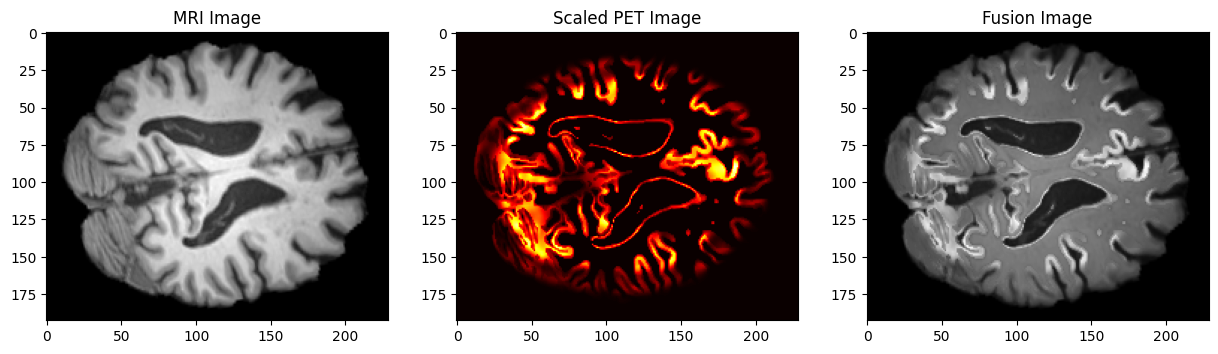

In [41]:
# Example usage:
fuse_images(r"D:\Data\Preprocessed\3. spatial_normalization\002_S_0295_MRI.nii", r"D:\Data\Preprocessed\6. Masked PET\002_S_0295_Masked_PET.nii", r"D:\Data\Preprocessed\7. Fused Image\002_S_0295_Fusion.nii", show_images=True)

In [42]:
import numpy as np

def calculate_correlation(original_data, fused_data):
    """
    Calculate the correlation coefficient between two images.
    """
    original_flattened = original_data.flatten()
    fused_flattened = fused_data.flatten()
    correlation = np.corrcoef(original_flattened, fused_flattened)[0, 1]
    return correlation

# Load your data as shown previously
mri_data = nib.load(r"D:\Data\Preprocessed\3. spatial_normalization\002_S_0295_MRI.nii",).get_fdata()
masked_pet_data = nib.load( r"D:\Data\Preprocessed\6. Masked PET\002_S_0295_Masked_PET.nii").get_fdata()
fused_data = nib.load(r"D:\Data\Preprocessed\7. Fused Image\002_S_0295_Fusion.nii").get_fdata()

# Calculate correlations
correlation_mri = calculate_correlation(mri_data, fused_data)
correlation_pet = calculate_correlation(masked_pet_data, fused_data)

print("Correlation with MRI data:", correlation_mri)
print("Correlation with Masked PET data:", correlation_pet)


Correlation with MRI data: 0.9280127891950892
Correlation with Masked PET data: 0.6182677881183005


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           356 non-null    int64  
 1   Subject              356 non-null    object 
 2   Project              356 non-null    object 
 3   Phase                356 non-null    object 
 4   Sex                  356 non-null    object 
 5   Weight               356 non-null    float64
 6   Research Group       356 non-null    object 
 7   APOE A1              352 non-null    float64
 8   APOE A2              352 non-null    float64
 9   Visit                356 non-null    object 
 10  Study Date           356 non-null    object 
 11  Archive Date         356 non-null    object 
 12  Age                  356 non-null    float64
 13  Global CDR           140 non-null    float64
 14  NPI-Q Total Score    64 non-null     float64
 15  MMSE Total Score     140 non-null    flo

In [3]:
import pandas as pd

# Assuming 'df' is your DataFrame
subject_info = df.groupby('Subject').agg({
    'Sex': 'first',
    'Weight': 'first',
    'Research Group': 'first',
    'APOE A1': 'first',
    'APOE A2': 'first',
    'Age': 'first'
}).reset_index()

print(subject_info)


        Subject Sex  Weight Research Group  APOE A1  APOE A2   Age
0    002_S_0295   M    73.0             CN      3.0      4.0  90.0
1    002_S_0413   F    57.6             CN      3.0      3.0  81.5
2    002_S_0685   F    68.9             CN      3.0      3.0  95.8
3    002_S_0729   F    65.8            MCI      3.0      4.0  71.3
4    002_S_1155   M    64.9            MCI      3.0      3.0  64.0
..          ...  ..     ...            ...      ...      ...   ...
173  941_S_4377   F   121.6           LMCI      3.0      4.0  69.5
174  941_S_4420   M    79.4           EMCI      3.0      3.0  81.5
175  941_S_4764   F    77.6           EMCI      3.0      3.0  82.8
176  941_S_5124   F    78.9            SMC      3.0      3.0  76.8
177  941_S_5193   F    88.9            SMC      3.0      3.0  72.6

[178 rows x 7 columns]


In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Example DataFrame
# Assuming 'subject_info' is your DataFrame and it includes a 'Research Group' column

# Initialize the StratifiedShuffleSplit object
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Creating the splits - here we split off the test set first
for train_val_idx, test_idx in splitter.split(subject_info, subject_info['Research Group']):
    train_val_set = subject_info.iloc[train_val_idx]
    test_set = subject_info.iloc[test_idx]

# Now split the train_val_set into training and validation sets (80% train, 20% validation of the remaining data)
train_size = int(0.8 * len(train_val_set))  # 80% of remaining data
validation_size = len(train_val_set) - train_size  # 20% of remaining data

# We use train_test_split again for simplicity, ensuring stratification
for train_idx, val_idx in splitter.split(train_val_set, train_val_set['Research Group']):
    train_set = train_val_set.iloc[train_idx]
    validation_set = train_val_set.iloc[val_idx]

# Display the results
print("Training set:\n", train_set['Research Group'].value_counts(normalize=True))
print("Validation set:\n", validation_set['Research Group'].value_counts(normalize=True))
print("Test set:\n", test_set['Research Group'].value_counts(normalize=True))


Training set:
 EMCI    0.300885
CN      0.292035
LMCI    0.150442
MCI     0.123894
SMC     0.070796
AD      0.061947
Name: Research Group, dtype: float64
Validation set:
 EMCI    0.310345
CN      0.275862
LMCI    0.172414
MCI     0.103448
AD      0.068966
SMC     0.068966
Name: Research Group, dtype: float64
Test set:
 CN      0.305556
EMCI    0.305556
LMCI    0.166667
MCI     0.111111
AD      0.055556
SMC     0.055556
Name: Research Group, dtype: float64


In [5]:
subject_info

,Subject,Sex,Weight,Research Group,APOE A1,APOE A2,Age
0,002_S_0295,M,73.0,CN,3.0,4.0,90.0
1,002_S_0413,F,57.6,CN,3.0,3.0,81.5
2,002_S_0685,F,68.9,CN,3.0,3.0,95.8
3,002_S_0729,F,65.8,MCI,3.0,4.0,71.3
4,002_S_1155,M,64.9,MCI,3.0,3.0,64.0
...,...,...,...,...,...,...,...
173,941_S_4377,F,121.6,LMCI,3.0,4.0,69.5
174,941_S_4420,M,79.4,EMCI,3.0,3.0,81.5
175,941_S_4764,F,77.6,EMCI,3.0,3.0,82.8
176,941_S_5124,F,78.9,SMC,3.0,3.0,76.8


In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming 'subject_info' is your DataFrame and it includes a 'Research Group' column

# Initialize the StratifiedShuffleSplit object
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Create a new column for the dataset split tags
subject_info['dataset_split'] = None

# First, split into test and the combined train/validation sets
for train_val_idx, test_idx in splitter.split(subject_info, subject_info['Research Group']):
    subject_info.loc[test_idx, 'dataset_split'] = 'test'
    train_val_set = subject_info.loc[train_val_idx]

# Now, split the train_val_set into training and validation
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
for train_idx, val_idx in splitter.split(train_val_set, train_val_set['Research Group']):
    subject_info.loc[train_val_set.index[train_idx], 'dataset_split'] = 'train'
    subject_info.loc[train_val_set.index[val_idx], 'dataset_split'] = 'validation'

# Check the distribution of each dataset split within each research group
print(subject_info['dataset_split'].value_counts())
print(subject_info.groupby(['Research Group', 'dataset_split']).size())


train         106
test           36
validation     36
Name: dataset_split, dtype: int64
Research Group  dataset_split
AD              test              2
                train             7
                validation        2
CN              test             11
                train            31
                validation       10
EMCI            test             11
                train            32
                validation       11
LMCI            test              6
                train            16
                validation        6
MCI             test              4
                train            13
                validation        4
SMC             test              2
                train             7
                validation        3
dtype: int64


In [3]:
import pandas as pd

subject_info = pd.read_excel(r"C:\Users\Micha\OneDrive - Høyskolen Kristiania\MsC Business Analytics\Master Thesis\Python\Subject_info.xlsx")

In [4]:
import os
import pandas as pd

# Define the path to the folder containing the .nii files
folder_path = r"data\processed"

# List all .nii files in the directory
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.nii')]

# Initialize a dictionary to hold the mapping of Subject IDs to file paths
subject_to_path = {}

# Loop through each file path
for file_path in file_paths:
    # Extract the filename from the path
    filename = os.path.basename(file_path)
    
    # Check if the filename contains any of the Subject IDs
    for subject_id in subject_info['Subject'].unique():
        if subject_id in filename:
            subject_to_path[subject_id] = file_path
            break  # Assuming only one file per subject, break after finding a match

# Map the found paths back to the DataFrame
subject_info['PATH'] = subject_info['Subject'].map(subject_to_path)

# Check the DataFrame to ensure paths were added correctly
print(subject_info.head())


      Subject Sex  Weight Research Group  APOE A1  APOE A2   Age  \
0  002_S_0295   M    73.0             CN      3.0      4.0  90.0   
1  002_S_0413   F    57.6             CN      3.0      3.0  81.5   
2  002_S_0685   F    68.9             CN      3.0      3.0  95.8   
3  002_S_0729   F    65.8            MCI      3.0      4.0  71.3   
4  002_S_1155   M    64.9            MCI      3.0      3.0  64.0   

  dataset_split                                          File_Path  \
0         train  C:\Users\Micha\OneDrive - Høyskolen Kristiania...   
1          test  C:\Users\Micha\OneDrive - Høyskolen Kristiania...   
2          test  C:\Users\Micha\OneDrive - Høyskolen Kristiania...   
3    validation  C:\Users\Micha\OneDrive - Høyskolen Kristiania...   
4         train  C:\Users\Micha\OneDrive - Høyskolen Kristiania...   

                                   File_Path_desktop  \
0  D:\Data\Preprocessed\Fused Images\002_S_0295_f...   
1  D:\Data\Preprocessed\Fused Images\002_S_0413_f...   
2 

In [5]:
subject_info.to_excel("references\Subject_info.xlsx", index=False)